In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.interpolate import splrep, splev

# out_dir = dir+"/plots/"
# if not os.path.exists(out_dir):
#     os.makedirs(out_dir)

In [2]:
# Load the data from the NPZ file from shooting method to validate model
loaded_data = np.load('../shooting_method/data_all.npz')

# Access the arrays using the keys ('r', 'A0', 'alpha0', 'phi0')
r = loaded_data['r']
A_shooting = loaded_data['A0']
alpha_shooting = loaded_data['alpha0']
phi_shooting = loaded_data['phi0']

In [3]:
# the compactified radial coord x
x = r/(r+1)

# interpolation coefficients
# in r
A_r_coeffs = splrep(r, A_shooting, k=3)
alpha_r_coeffs = splrep(r, alpha_shooting, k=3)
phi_r_coeffs = splrep(r, phi_shooting, k=3)
# in x
A_x_coeffs = splrep(x, A_shooting, k=3)
alpha_x_coeffs = splrep(x, alpha_shooting, k=3)
phi_x_coeffs = splrep(x, phi_shooting, k=3)

# interpolated functions
# r
A_r_itp = splev(r, A_r_coeffs)
alpha_r_itp = splev(r, alpha_r_coeffs)
phi_r_itp = splev(r, phi_r_coeffs)
# x
A_x_itp = splev(x, A_x_coeffs)
alpha_x_itp = splev(x, alpha_x_coeffs)
phi_x_itp = splev(x, phi_x_coeffs)


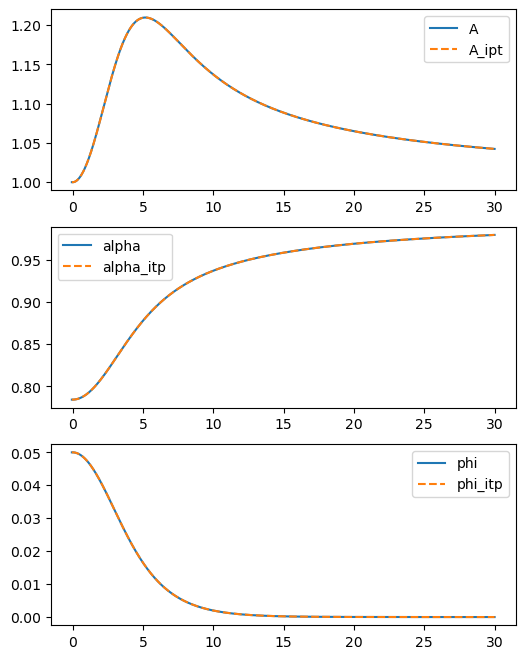

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8))

axs[0].plot(r, A_shooting, label="A")
axs[0].plot(r, A_r_itp, label="A_ipt", ls="--")
axs[0].legend()

axs[1].plot(r, alpha_shooting, label="alpha")
axs[1].plot(r, alpha_r_itp, label="alpha_itp", ls="--")
axs[1].legend()

axs[2].plot(r, phi_shooting, label="phi")
axs[2].plot(r, phi_r_itp, label="phi_itp", ls="--")
axs[2].legend()


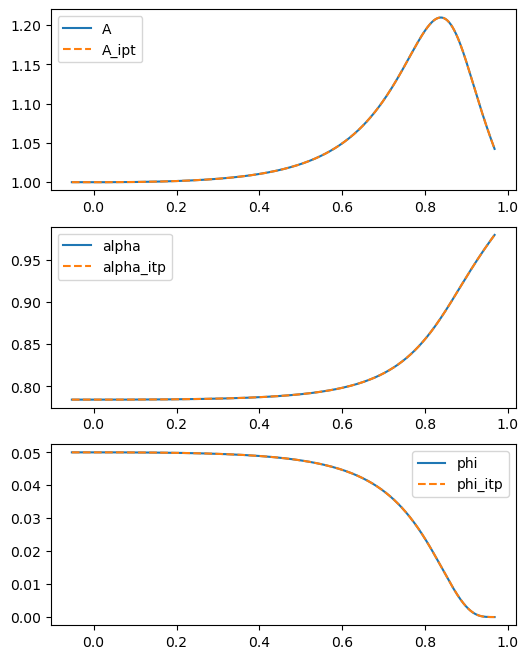

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8))

axs[0].plot(x, A_shooting, label="A")
axs[0].plot(x, A_x_itp, label="A_ipt", ls="--")
axs[0].legend()

axs[1].plot(x, alpha_shooting, label="alpha")
axs[1].plot(x, alpha_x_itp, label="alpha_itp", ls="--")
axs[1].legend()

axs[2].plot(x, phi_shooting, label="phi")
axs[2].plot(x, phi_x_itp, label="phi_itp", ls="--")
axs[2].legend()


In [6]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        act = torch.nn.Softplus()
        x = act(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [7]:
# copied from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [8]:
# random (uniform) sample points in (0,1).
def random_domain_points(n):
    #x = torch.rand((n,1), requires_grad=True)
    xhigh = 0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # [0.5,1)
    xlow  = -0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # (0,0.5]
    x = torch.cat((xlow, xhigh),0)
    return x

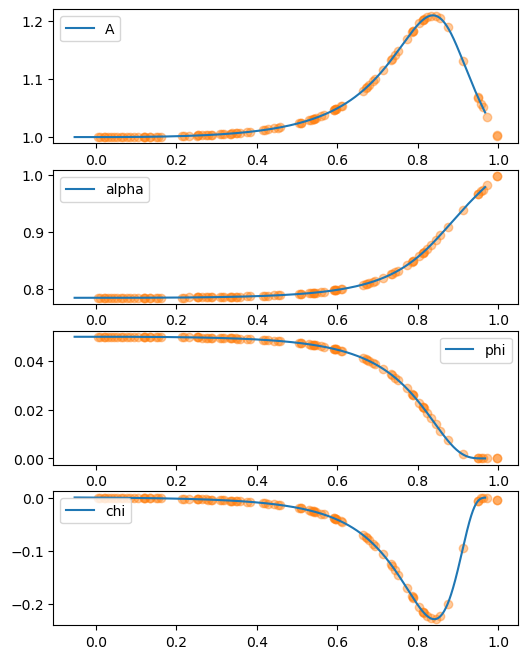

In [9]:
# do this training on cp
device = torch.device("cpu")

# generate the random points from the interpolated function to train on
n = 100
rand = random_domain_points(n).to(device)

rand2 = rand.detach().cpu().numpy()

A_rand = splev(rand2, A_x_coeffs)
alpha_rand = splev(rand2, alpha_x_coeffs)
phi_rand = splev(rand2, phi_x_coeffs)
chi_rand = splev(rand2, phi_x_coeffs, der=1)
# it's missing from shooting; generated from interpolation
chi = splev(x, phi_x_coeffs, der=1) 

fig, axs = plt.subplots(4, 1, figsize=(6, 8))

axs[0].plot(x, A_shooting, label="A")
axs[0].scatter(rand2, A_rand, alpha=0.4, color="tab:orange")
axs[0].legend()

axs[1].plot(x, alpha_shooting, label="alpha")
axs[1].scatter(rand2, alpha_rand, alpha=0.4, color="tab:orange")
axs[1].legend()

axs[2].plot(x, phi_shooting, label="phi")
axs[2].scatter(rand2, phi_rand, alpha=0.4, color="tab:orange")
axs[2].legend()

axs[3].plot(x, chi, label="chi")
axs[3].scatter(rand2, chi_rand, alpha=0.4, color="tab:orange")
axs[3].legend()


In [10]:
def domain_loss_sampling(u, A_rand, alpha_rand, phi_rand, chi_rand): 
    A, alpha, chi_minus, phi = map(lambda i:  u[:,[i]], range(4))
    #  s.t. all vars are positive
    chi = - chi_minus

    # A residual
    A_res = A - A_rand
    # alpha residual
    alpha_res = alpha - alpha_rand
    # phi residual
    phi_res = phi - phi_rand
    # chi residual
    chi_res = chi - chi_rand
    
    loss_dom = (
        torch.mean(torch.pow(A_res, 2)) +
        torch.mean(torch.pow(alpha_res, 2)) +
        torch.mean(torch.pow(chi_res, 2)) +
        torch.mean(torch.pow(phi_res, 2)) 
               )
               
    return loss_dom

In [11]:
model = FCN(1,4,64,4).to(device)

optimizer = torch.optim.Adam(list(model.parameters()),lr=1e-4)

DECAY_RATE = 0.95
DECAY_STEPS = 2000
gamma = DECAY_RATE ** (1 / DECAY_STEPS)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

epochs = 100000

loss_list = []
print_message = 50


In [12]:
# Convert targets to tensors (these do not require gradients)
A_rand_tensor = torch.tensor(A_rand, dtype=torch.float32, device=device)
alpha_rand_tensor = torch.tensor(alpha_rand, dtype=torch.float32, device=device)
phi_rand_tensor = torch.tensor(phi_rand, dtype=torch.float32, device=device)
chi_rand_tensor = torch.tensor(chi_rand, dtype=torch.float32, device=device)

for i in range(int(epochs)):
    optimizer.zero_grad() # to make the gradients zero
    
    u = model(rand)
    
    loss = domain_loss_sampling(u, A_rand_tensor, alpha_rand_tensor,
                       phi_rand_tensor, chi_rand_tensor)

    # save loss
    loss_list.append(loss.item())
    current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate

    # print message
    if (i+1)%print_message==0:
        #print(f'Epoch: {i+1} - Loss: {loss.item():>1.3e} - Learning Rate: {current_lr:>1.3e}')
        print('epoch = ', i+1, '| loss = ', loss.item(),'| Learning Rate = ', current_lr, '|',  end='\r')

    # detach() removes the "requires_grad" and numpy() makes it a numpy item to plot later
    loss.backward(retain_graph=True) # This is for computing gradients using backward propagation
    optimizer.step()
    scheduler.step()

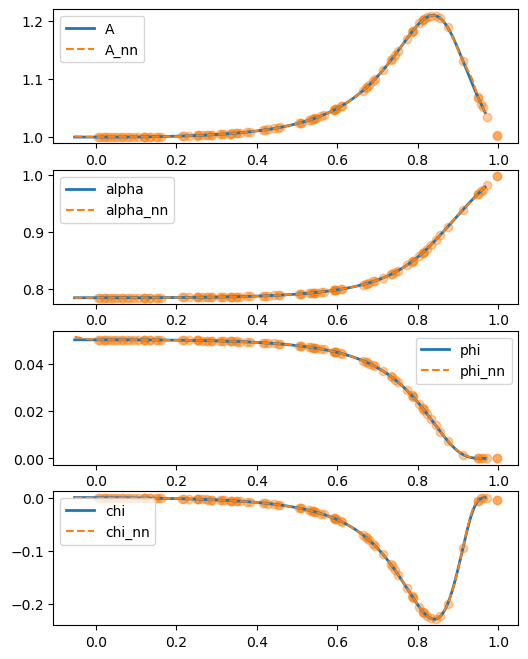

In [13]:
x_tensor = torch.from_numpy(x).float().unsqueeze(1)

sol_nn = model(x_tensor).detach().numpy()

A_nn = sol_nn[:,[0]]
alpha_nn = sol_nn[:,[1]]
chi_nn = -sol_nn[:,[2]]
phi_nn = sol_nn[:,[3]]

fig, axs = plt.subplots(4, 1, figsize=(6, 8))

axs[0].plot(x, A_shooting, label="A", lw=2)
axs[0].plot(x, A_nn, label="A_nn", ls="--")
axs[0].scatter(rand2, A_rand, alpha=0.4, color="tab:orange")
axs[0].legend()

axs[1].plot(x, alpha_shooting, label="alpha", lw=2)
axs[1].plot(x, alpha_nn, label="alpha_nn", ls="--")
axs[1].scatter(rand2, alpha_rand, alpha=0.4, color="tab:orange")
axs[1].legend()

axs[2].plot(x, phi_shooting, label="phi", lw=2)
axs[2].plot(x, phi_nn, label="phi_nn", ls="--")
axs[2].scatter(rand2, phi_rand, alpha=0.4, color="tab:orange")
axs[2].legend()

axs[3].plot(x, chi, label="chi", lw=2)
axs[3].plot(x, chi_nn, label="chi_nn", ls="--")
axs[3].scatter(rand2, chi_rand, alpha=0.4, color="tab:orange")
axs[3].legend()

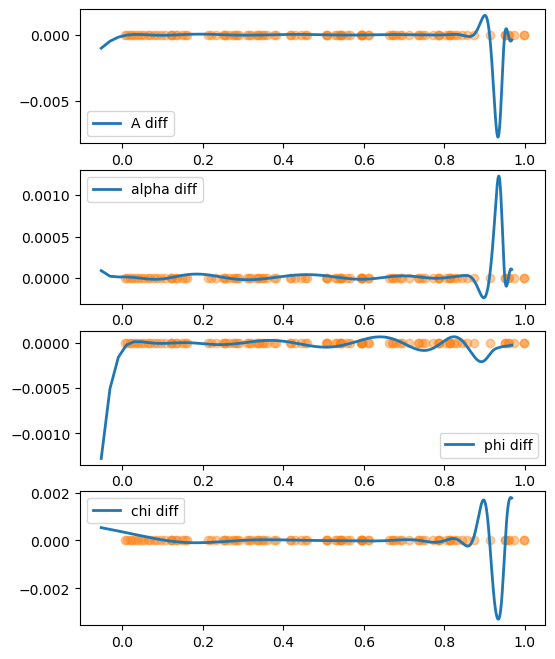

In [14]:
A_diff = A_shooting-A_nn.squeeze()
alpha_diff = alpha_shooting - alpha_nn.squeeze()
phi_diff = phi_shooting - phi_nn.squeeze()
chi_diff = chi - chi_nn.squeeze()

rand_zeros = rand2*0.0

fig, axs = plt.subplots(4, 1, figsize=(6, 8))

axs[0].plot(x, A_diff, label="A diff", lw=2)
axs[0].scatter(rand2, rand_zeros, alpha=0.4, color="tab:orange")
axs[0].legend()

axs[1].plot(x, alpha_diff, label="alpha diff", lw=2)
axs[1].scatter(rand2, rand_zeros, alpha=0.4, color="tab:orange")
axs[1].legend()

axs[2].plot(x, phi_diff, label="phi diff", lw=2)
axs[2].scatter(rand2, rand_zeros, alpha=0.4, color="tab:orange")
axs[2].legend()

axs[3].plot(x, chi_diff, label="chi diff", lw=2)
axs[3].scatter(rand2, rand_zeros, alpha=0.4, color="tab:orange")
axs[3].legend()

Before the model was trained on a fixed set of random points.

Now, we are going to regenerate this points for every epoch, and compare which traininig method works best.

In [15]:
model2 = FCN(1,4,64,4).to(device)

optimizer2 = torch.optim.Adam(list(model2.parameters()),lr=1e-4)

DECAY_RATE = 0.95
DECAY_STEPS = 2000
gamma2 = DECAY_RATE ** (1 / DECAY_STEPS)

scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer2, gamma=gamma2)

epochs = 100000

loss_list2 = []
print_message = 50

In [16]:
# generate the random points from the interpolated function to train on
n = 100

# list to save all the random points
rand_all = []
A_rand_all = []
alpha_rand_all = []
phi_rand_all = []
chi_rand_all = []

resample_every = 1000

for i in range(int(epochs)):
    optimizer2.zero_grad() # to make the gradients zero

    if i%resample_every==0:
        rand = random_domain_points(n).to(device)
        rand2 = rand.detach().cpu().numpy()
        rand_all.append(rand2.squeeze())

        A_rand = splev(rand2, A_x_coeffs)
        alpha_rand = splev(rand2, alpha_x_coeffs)
        phi_rand = splev(rand2, phi_x_coeffs)
        chi_rand = splev(rand2, phi_x_coeffs, der=1)
        # it's missing from shooting; generated from interpolation
        chi = splev(x, phi_x_coeffs, der=1)
        # save the random training points
        A_rand_all.append(A_rand.squeeze())
        alpha_rand_all.append(alpha_rand.squeeze())
        phi_rand_all.append(phi_rand.squeeze())
        chi_rand_all.append(chi_rand.squeeze())


    # Convert targets to tensors (these do not require gradients)
    A_rand_tensor = torch.tensor(A_rand, dtype=torch.float32, device=device)
    alpha_rand_tensor = torch.tensor(alpha_rand, dtype=torch.float32, device=device)
    phi_rand_tensor = torch.tensor(phi_rand, dtype=torch.float32, device=device)
    chi_rand_tensor = torch.tensor(chi_rand, dtype=torch.float32, device=device)

    u = model2(rand)
    
    loss2 = domain_loss_sampling(u, A_rand_tensor, alpha_rand_tensor,
                       phi_rand_tensor, chi_rand_tensor)

    # save loss
    loss_list2.append(loss2.item())
    current_lr = scheduler2.get_last_lr()[0]  # Get the current learning rate

    # print message
    if (i+1)%print_message==0:
        #print(f'Epoch: {i+1} - Loss: {loss.item():>1.3e} - Learning Rate: {current_lr:>1.3e}')
        print('epoch = ', i+1, '| loss = ', loss2.item(),'| Learning Rate = ', current_lr, '|',  end='\r')

    # detach() removes the "requires_grad" and numpy() makes it a numpy item to plot later
    loss2.backward(retain_graph=True) # This is for computing gradients using backward propagation
    optimizer2.step()
    scheduler2.step()

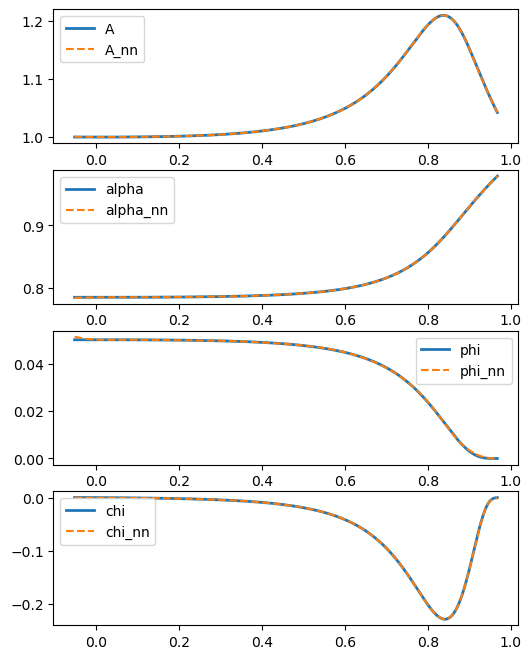

In [17]:
x_tensor = torch.from_numpy(x).float().unsqueeze(1)

sol_nn2 = model2(x_tensor).detach().numpy()

A_nn2 = sol_nn2[:,[0]]
alpha_nn2 = sol_nn2[:,[1]]
chi_nn2 = -sol_nn2[:,[2]]
phi_nn2 = sol_nn2[:,[3]]

fig, axs = plt.subplots(4, 1, figsize=(6, 8))

axs[0].plot(x, A_shooting, label="A", lw=2)
axs[0].plot(x, A_nn2, label="A_nn", ls="--")
#axs[0].scatter(np.concatenate(rand_all), np.concatenate(A_rand_all) , alpha=0.4, color="tab:orange")
axs[0].legend()

axs[1].plot(x, alpha_shooting, label="alpha", lw=2)
axs[1].plot(x, alpha_nn2, label="alpha_nn", ls="--")
#axs[1].scatter(np.concatenate(rand_all), np.concatenate(alpha_rand_all), alpha=0.4, color="tab:orange")
axs[1].legend()

axs[2].plot(x, phi_shooting, label="phi", lw=2)
axs[2].plot(x, phi_nn2, label="phi_nn", ls="--")
#axs[2].scatter(np.concatenate(rand_all), np.concatenate(phi_rand_all), alpha=0.4, color="tab:orange")
axs[2].legend()

axs[3].plot(x, chi, label="chi", lw=2)
axs[3].plot(x, chi_nn2, label="chi_nn", ls="--")
#axs[3].scatter(np.concatenate(rand_all), np.concatenate(chi_rand_all), alpha=0.4, color="tab:orange")
axs[3].legend()

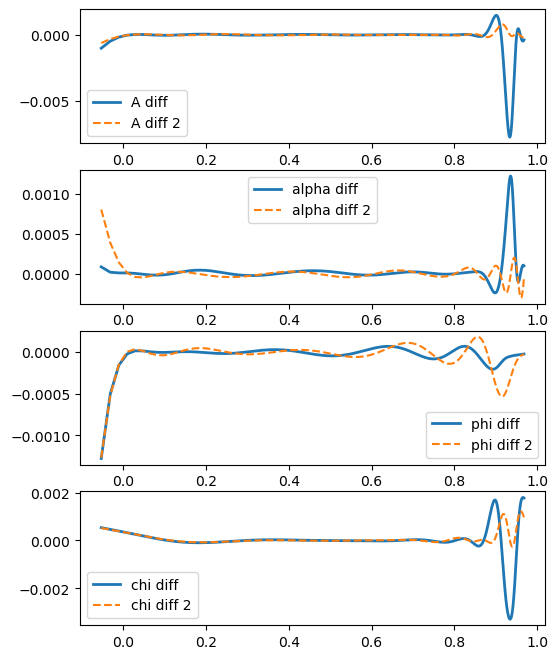

In [18]:
A_diff2 = A_shooting-A_nn2.squeeze()
alpha_diff2 = alpha_shooting - alpha_nn2.squeeze()
phi_diff2 = phi_shooting - phi_nn2.squeeze()
chi_diff2 = chi - chi_nn2.squeeze()

fig, axs = plt.subplots(4, 1, figsize=(6, 8))

axs[0].plot(x, A_diff, label="A diff", lw=2)
axs[0].plot(x, A_diff2, label="A diff 2", lw=1.5, ls="--")
axs[0].legend()

axs[1].plot(x, alpha_diff, label="alpha diff", lw=2)
axs[1].plot(x, alpha_diff2, label="alpha diff 2", lw=1.5, ls="--")
axs[1].legend()

axs[2].plot(x, phi_diff, label="phi diff", lw=2)
axs[2].plot(x, phi_diff2, label="phi diff 2", lw=1.5, ls="--")
axs[2].legend()

axs[3].plot(x, chi_diff, label="chi diff", lw=2)
axs[3].plot(x, chi_diff2, label="chi diff 2", lw=1.5, ls="--")
axs[3].legend()

check how these solutions satisfy the loss functions we use for the PINN (no actual datapoints of the unknown functions for training)

In [ ]:
def domain_loss(u, x, omega, m): 
    A, alpha, chi_minus, phi = map(lambda i:  u[:,[i]], range(4))
    #  s.t. all vars are positive
    chi = - chi_minus
    # take derivatives
    Ax = gradients(A, x)
    alphax = gradients(alpha, x)
    chix = gradients(chi, x)
    phix = gradients(phi, x)
    
    omega = omega#.to(device)
    
    # potential
    V = 0.5*torch.pow(m,2)*torch.pow(phi,2)
    # potential derivative wrt phi
    dVdphi = torch.pow(m,2)*phi
    # rho
    rho = 0.5*(torch.pow(chi,2)/A + torch.pow((omega/alpha),2)*torch.pow(phi,2)) + V
    # S_A
    SA = 0.5*(torch.pow(chi,2)/A + torch.pow((omega/alpha),2)*torch.pow(phi,2)) - V
    # eq_A is x*((1-x)^3)*\p_x A - x*((1-x)^3)*rhs[A]
    eq_A = x*((1-x)**3)*Ax -((1-x)**2)*A*(1-A) - 8*torch.pi*(x**2)*(A**2)*rho
    # eq_alpha is x*((1-x)^3)*\p_x alpha - x*((1-x)^3)*rhs[alpha]
    eq_alpha = x*((1-x)**3)*alphax - alpha*( 0.5*(A-1)*(1-x)**2 + 8*torch.pi*A*(x**2)*SA)
    # eq_chi  is x*((1-x)^2)*chi - x*((1-x)^2)*rhs[chi]
    eq_chi = x*((1-x)**2)*chix + chi*( (1+A)*(1-x) - 8*torch.pi*x*A*V) - x*A*(dVdphi - torch.pow((omega/alpha),2)*phi)
    # eq_phi is ((1-x)^2)*\p_x phi - rhs[phi]
    eq_phi = ((1-x)**2)*phix - chi

    loss_dom = (torch.mean(torch.pow(eq_A,2)) + torch.mean(torch.pow(eq_alpha,2))
                + torch.mean(torch.pow(eq_chi,2)) + torch.mean(torch.pow(eq_phi,2)) 
               )
    
    return loss_dom

def x0_loss(u0, x0, phi0):    
    A, alpha, chi_minus, phi = map(lambda i:  u0[[i]], range(4))
    chi = - chi_minus
    # take derivatives
    alphax = gradients(alpha, x0)
    
    loss_x0 = torch.mean(torch.pow(A-1,2)) + torch.mean(torch.pow(alphax,2)) + torch.mean(torch.pow(phi-phi0,2)) + torch.mean(torch.pow(chi,2))
    return loss_x0

def x1_loss(u1):
    A, alpha, chi_minus, phi = map(lambda i:  u1[[i]], range(4))
    chi = - chi_minus

    loss_rmax = torch.mean(torch.pow(A-1,2)) + torch.mean(torch.pow(alpha-1,2)) + torch.mean(torch.pow(phi,2)) + torch.mean(torch.pow(chi,2))
    return loss_rmax

# impose that phi is a monotonically decreasing function
def phi_monotonic_decrease_dom(u,x):
    A, alpha, chi_minus, phi = map(lambda i:  u[:,[i]], range(4))
    chi = - chi_minus
    phix = gradients(phi, x)
    m = torch.nn.ReLU()
    penalty = torch.mean(torch.pow(m(phix),2))
    return penalty

# impose that alpha is a monotonically increasing function
def alpha_monotonic_increase_dom(u,x):
    A, alpha, chi_minus, phi = map(lambda i:  u[:,[i]], range(4))
    chi = - chi_minus
    alphax = gradients(alpha, x)
    m = torch.nn.ReLU()
    penalty = torch.mean(torch.pow(m(-alphax),2))
    return penalty

In [46]:
omega = 0.895042 * torch.ones(1).to(device)
phi0  = 0.05  * torch.ones(1).to(device)
m = torch.ones(1).to(device)

# Define weights for each loss term
w0 = 1000.0  # Weight for r0_loss
w1 = 1.0  # Weight for domain_loss
w2 = 1000.0  # Weight for rmax_loss
w3 = 1000.0  # Weight for phi_monotonic_decrease
w4 = 1000.0  # Weight for alpha_monotonic_increase

x0 = torch.zeros(1, requires_grad=True).to(device)
# loss at x=0, model1
u0 = model(x0)
loss_x0 = x0_loss(u0, x0, phi0)
# model 2
u0_2 = model2(x0)
loss_x0_2 = x0_loss(u0_2, x0, phi0)
# the bulk loss and monotonicity penalties
x = random_domain_points(10000).to(device) # uniform points in (0,1)
# model 1
u = model(x)
loss_dom = domain_loss(u, x, omega, m)
phi_mono_decrease = phi_monotonic_decrease_dom(u, x)
alpha_mono_increase = alpha_monotonic_increase_dom(u, x)
# model 2
u_2 = model2(x)
loss_dom_2 = domain_loss(u_2, x, omega, m)
phi_mono_decrease_2 = phi_monotonic_decrease_dom(u_2, x)
alpha_mono_increase_2 = alpha_monotonic_increase_dom(u_2, x)
# loss at x1=1
x1 = torch.ones(1, requires_grad=True).to(device)
# model 1
ux1 = model(x1)
loss_x1 = x1_loss(ux1)
u_2_x1 = model2(x1)
loss_x1_2 = x1_loss(u_2_x1)

# Total loss
loss = (w0 * loss_x0 + w1 * loss_dom + w2 * loss_x1 + w3 * phi_mono_decrease + w4 * alpha_mono_increase)

In [47]:
print("model 1")
print("loss_dom =", loss_dom.detach().numpy())
print("loss_x0 =", loss_x0.detach().numpy())
print("loss_x1 =", loss_x1.detach().numpy())
print("phi_mono_decrease =", phi_mono_decrease.detach().numpy())
print("alpha_mono_increase =", alpha_mono_increase.detach().numpy())
print()
print("model 2")
print("loss_dom =", loss_dom_2.detach().numpy())
print("loss_x0 =", loss_x0_2.detach().numpy())
print("loss_x1 =", loss_x1_2.detach().numpy())
print("phi_mono_decrease =", phi_mono_decrease_2.detach().numpy())
print("alpha_mono_increase =", alpha_mono_increase_2.detach().numpy())

model 1
loss_dom = 0.0066461167
loss_x0 = 1.3957727e-07
loss_x1 = 1.9544386e-06
phi_mono_decrease = 1.0686358e-09
alpha_mono_increase = 6.208654e-14

model 2
loss_dom = 0.006647434
loss_x0 = 4.142728e-05
loss_x1 = 6.846073e-07
phi_mono_decrease = 6.737103e-08
alpha_mono_increase = 3.9512657e-10
